## Phase 1 — Problem Definition

The goal of this project is to predict the number of bike rentals per hour
based on temporal, calendar, and weather-related features.

This is a regression problem, since the target variable is numerical and
represents the total number of rented bikes (cnt).

## Import necessary libraries


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from sklearn.inspection import permutation_importance


# Phase 2 - Data Understanding & Preparation

The Bike Sharing dataset (hourly version) was used in this project.
Each row represents one hour of bike rental activity.
In this Phase is performed an initial inspection of the dataset, to understand the structure, size and data types.

### 2.1 Data understanding

Load the dataset, and check the first 5 lines.

After a first look at the dataset, it helps to conclude that:
- columns are parsed corretly
- values look consistent
- the target variable ´cnt´ is available

In [34]:
# Load the dataset
df = pd.read_csv("hour.csv")


# Display first rows
df.head()


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Check the shape of the dataset (Number of rows and columns) and the types of each variable

In [35]:
print("\n-------- Shape ---------")
print(df.shape)
print("\n--------- Info --------")
print(df.info())


-------- Shape ---------
(17379, 17)

--------- Info --------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory u

In [36]:
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


### 2.2 Data Cleaning and Preprocessing
The dataset was checked for missing values and duplicated rows.
If there where missing values, they would need to be handel with impution or elimination.

In [37]:
# Missing values
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [38]:
# Duplicated rows
df.duplicated().sum()

np.int64(0)

### Target variable
- cnt is defined as the total number of bike rentals per hour and will be used as the target.

### Columns excluded from features
Some columns should not be used as model inputs:

- instant: a sequential identifier with no predictive meaning.
- casual and registered: these represent components of the target, since  
  cnt = casual + registered. Including them would introduce **data leakage**.  
- atemp: this variable causes multicollinearity issues with the variable temp (correlation of 0.99 with temp)

After removing these columns, the remaining variables are used as input features for the model.

In [39]:
cols_to_drop = ["instant", "casual", "registered", "atemp"]
df = df.drop(columns=cols_to_drop, errors="ignore")

### 2.3 Date Feature Engineering

Only one variable was non-numerical , namely "dteday", so it was transformed into a numerical feature by extracting
the day of the month. The original date column was then removed.


In [40]:
df["dteday"] = pd.to_datetime(df["dteday"])

# Extract the day of the month as a numerical feature
df["day"] = df["dteday"].dt.day

# the original date column was removed
df = df.drop(columns=["dteday"])

### 2.4 Exploratory Data Analysis

Several visual analyses were performed to better understand the relationships
between the features and the target variable.

#### Target Distribution 
The distribution of cnt was analyzed to understand demand variability and guide subsequent modeling decisions.

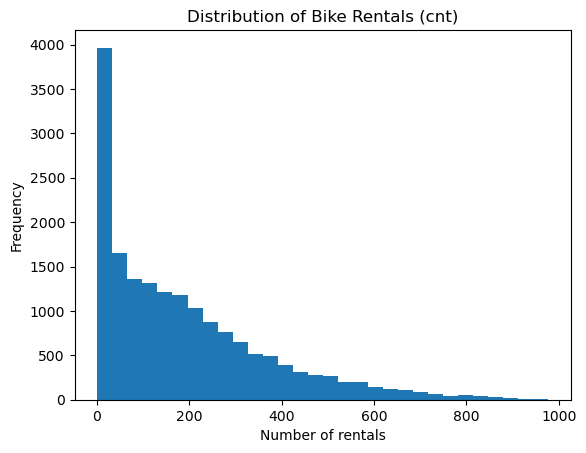

In [41]:
plt.figure()
plt.hist(df["cnt"], bins=30)
plt.title("Distribution of Bike Rentals (cnt)")
plt.xlabel("Number of rentals")
plt.ylabel("Frequency")
plt.show()

### Correlation Analysis (Pearson)

A correlation heatmap was used to analyze linear relationships
between numerical variables.

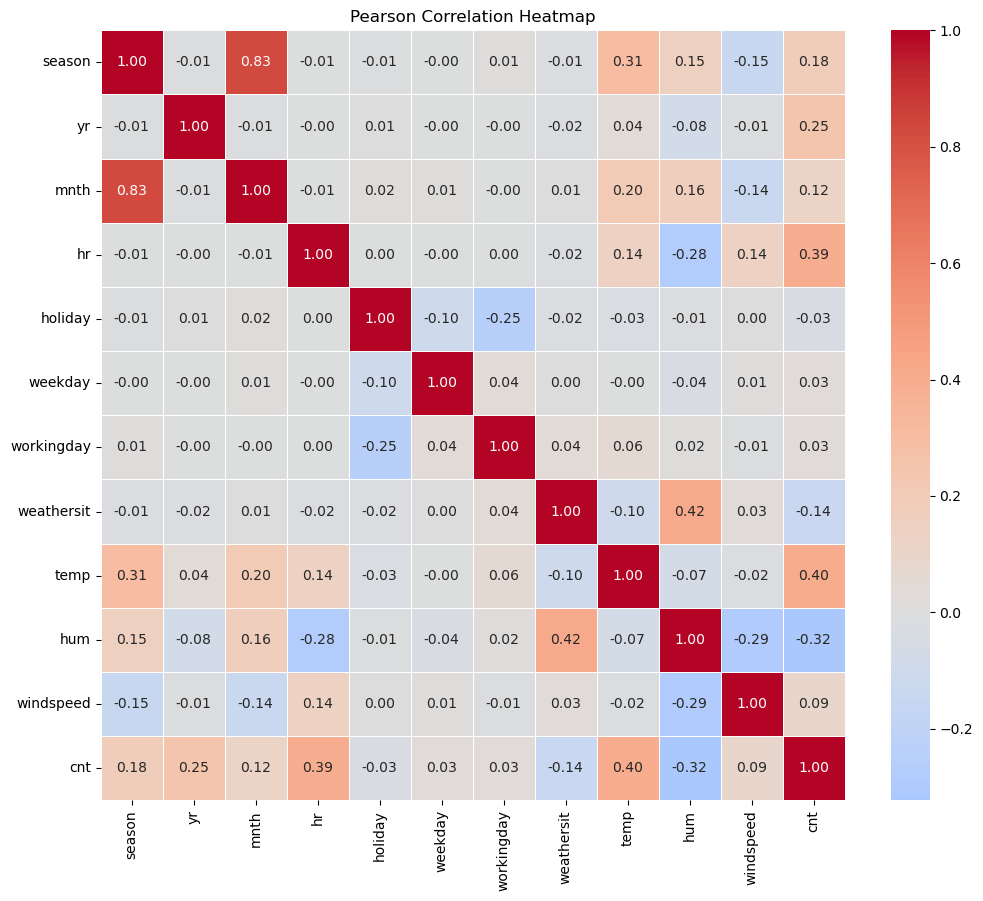

In [42]:
# Select numerical columns only
numeric_df = df.select_dtypes(include=["int64", "float64"])

# Pearson correlation matrix
corr_matrix = numeric_df.corr(method="pearson")


plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    annot=True,         
    fmt=".2f"            
)
plt.title("Pearson Correlation Heatmap")
plt.show()

From the heatmap, it is possible to observe that the variables **hour (hr)**, **temperature (temp)** present the strongest positive correlations with the number of bike rentals. This indicates that both the time of day and weather conditions play an important role in bike rental demand.

Humidity (hum) shows a moderate negative correlation with cnt, wich can indicate that higher humidity levels are generally associated with lower bike rental demand. Weather situation (weathersit) also presents a negative correlation with the target variable, suggesting the reduced usage under worse weather conditions.

Calendar-related variables such as holiday, weekday, and workingday exhibit weak linear correlations with the target variable. This suggests that their influence on bike rental demand may be more complex or non-linear, which motivates the use of tree-based models.

Overall, the correlation analysis shows the importance of temporal and weather-related features and supports the choice of a non-linear model

### Bike Rentals by Hour of the Day

This plot shows the average number of rentals for each hour,
highlighting peak usage periods.

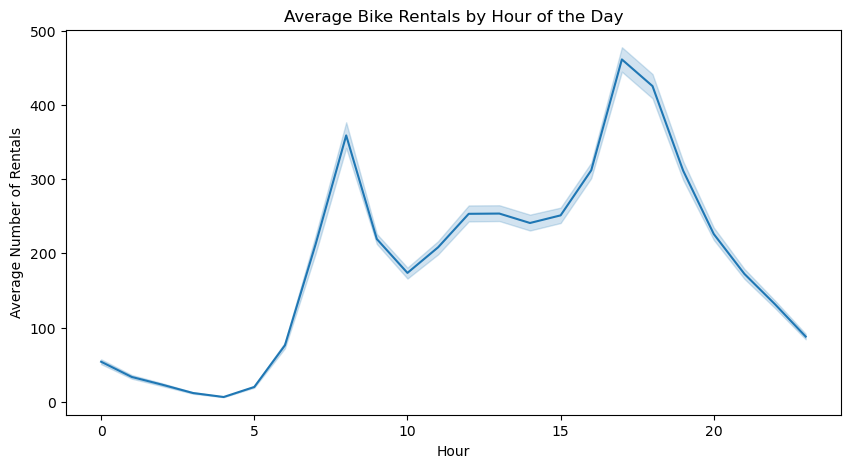

In [43]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="hr", y="cnt", estimator="mean")
plt.title("Average Bike Rentals by Hour of the Day")
plt.xlabel("Hour")
plt.ylabel("Average Number of Rentals")
plt.show()

 A clear daily pattern can be observed, with two main peaks occurring during the morning and late afternoon hours. These peaks are consistent with typical commuting times, indicating a higher demand during work-related travel periods.

During late night and early morning hours, the number of rentals is significantly lower. This strong hourly pattern demonstrate the importance of the ***hr*** variable and suggests a non-linear relationship between time of day and bike rental demand.

### Bike Rentals vs Temperature

This scatter plot illustrates the relationship between temperature
and bike rental demand.

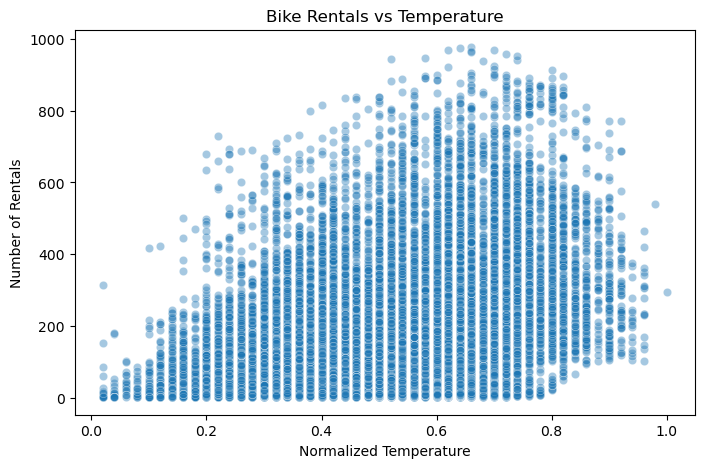

In [44]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="temp", y="cnt", alpha=0.4)
plt.title("Bike Rentals vs Temperature")
plt.xlabel("Normalized Temperature")
plt.ylabel("Number of Rentals")
plt.show()

 In general, higher temperatures are associated with increased bike rental demand, the highest number of rentals tends to occur at moderate to warm temperatures.

However, the relationship is not strictly linear, as there is a noticeable spread of values for similar temperature levels. This indicates that temperature interacts with other factors, such as time of day or weather conditions, reinforcing the need for models capable of capturing non-linear relationships.

### Bike Rentals: Weekday vs Weekend

This boxplot compares rental distributions between weekdays and weekends.

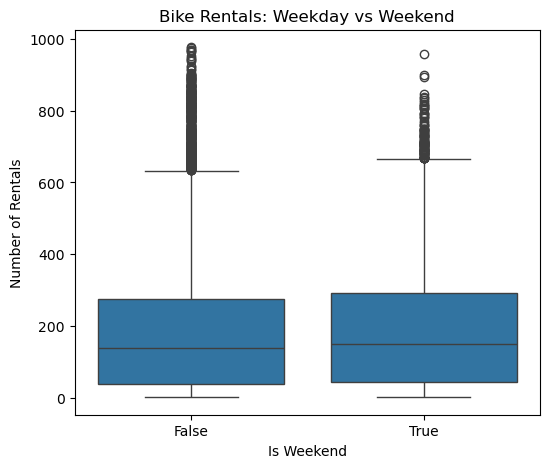

In [45]:
# Create weekend indicator
df["is_weekend"] = df["weekday"].isin([5, 6])

plt.figure(figsize=(6, 5))
sns.boxplot(data=df, x="is_weekend", y="cnt")
plt.title("Bike Rentals: Weekday vs Weekend")
plt.xlabel("Is Weekend")
plt.ylabel("Number of Rentals")
plt.show()

In [46]:
df = df.drop(columns=["is_weekend"])

 While the median number of rentals is slightly higher during weekends, both categories show high variability and a wide range of values.

The presence of numerous extreme values reflects the peak usage periods and reveal the diverse usage patterns across different days. This suggests that calendar-related variables influence bike rental demand, but their effect may depend on other contextual factors such as time of day and weather.

### Bike Rentals: Holiday vs Non-Holiday

This visualization highlights the impact of holidays on rental demand.



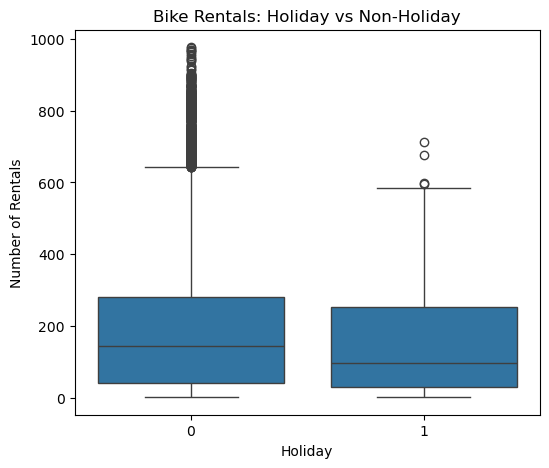

In [47]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=df, x="holiday", y="cnt")
plt.title("Bike Rentals: Holiday vs Non-Holiday")
plt.xlabel("Holiday")
plt.ylabel("Number of Rentals")
plt.show()

 Overall, bike rentals tend to be lower on holidays, as reflected by a lower median value. Additionally, the distribution for holidays shows fewer high-demand instances, which may be related to reduced commuting activity.

It is important to note that holidays represent a smaller portion of the dataset, which limits the strength of this observation. Nevertheless, the analysis suggests that holidays have an impact on bike rental behavior.

## Phase 3 — Model Selection

Different regression models were considered, balancing simplicity,
performance, and interpretability.

The following models were selected for comparison:
- Linear Regression (baseline)
- Decision Tree Regressor
- Random Forest Regressor
- Gradient Boosting Regressor

## Phase 4 — Implementation & Experimentation

In this phase, the selected regression models are implemented and trained using the same train/test split.
The goal is to perform an initial comparison between models and identify the most promising approach.

### 4.1 Train/Test split
The dataset is split into training and test sets (80/20). 

In [48]:
# Target variable
y = df["cnt"]

# Features
X = df.drop(columns=["cnt"])

# Split the data into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape

((13903, 12), (3476, 12))

### 4.2 Evaluation function
All models are evaluated using the same regression metrics:
- **MAE**: average absolute error
- **RMSE**: penalizes larger errors
- **R²**: proportion of variance explained

In [49]:
def evaluate_regression_model(model, X_test, y_test):
    """
    Evaluate a regression model using MAE, RMSE and R².

    """
    y_pred = model.predict(X_test)

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    r2 = r2_score(y_test, y_pred)

    return {"MAE": mae, "RMSE": rmse, "R2": r2}

### 4.3 Train and compare models
Three regression models are trained under the same train/test split:
1. Linear Regression (baseline)
2. Decision Tree Regressor
3. Random Forest Regressor

The goal is to compare model performance and identify the most suitable approach.

In [50]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_metrics = evaluate_regression_model(lr, X_test, y_test)
lr_metrics

{'MAE': 104.9608349623673,
 'RMSE': np.float64(139.41741315417946),
 'R2': 0.38616887416760337}

In [51]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)

dt_metrics = evaluate_regression_model(dt, X_test, y_test)
dt_metrics

{'MAE': 34.59982738780207,
 'RMSE': np.float64(60.87707388073759),
 'R2': 0.8829632091336832}

In [52]:
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

rf_metrics = evaluate_regression_model(rf, X_test, y_test)
rf_metrics

{'MAE': 24.493895281933256,
 'RMSE': np.float64(41.79400764790692),
 'R2': 0.9448376319286191}

In [53]:
hgb = HistGradientBoostingRegressor(random_state=42)
hgb.fit(X_train, y_train)

hgb_metrics = evaluate_regression_model(hgb, X_test, y_test)
hgb_metrics

{'MAE': 24.903086078290638,
 'RMSE': np.float64(39.40063485806577),
 'R2': 0.9509745819903082}



The models were evaluated using MAE, RMSE, and R².

In [54]:
# Results summary table
results = pd.DataFrame([
    {"Model": "Linear Regression", **lr_metrics},
    {"Model": "Decision Tree", **dt_metrics},
    {"Model": "Random Forest", **rf_metrics},
    {"Model": "Gradient Boosting (HGB)", **hgb_metrics},
])

results

,Model,MAE,RMSE,R2
0,Linear Regression,104.960835,139.417413,0.386169
1,Decision Tree,34.599827,60.877074,0.882963
2,Random Forest,24.493895,41.794008,0.944838
3,Gradient Boosting (HGB),24.903086,39.400635,0.950975


In the initial results, the Random Forest and the HistGradientBoosting models showed the best overall performance compared to the other two models.

## Phase 5 – Evaluation & Validation

This initial comparison made it possible to identify the most promising models for further exploration. Consequently, hyperparameter tuning was performed for both the Random Forest and the HistGradientBoosting models.

### 5.1 Manual Hyperparameter Tuning – Random Forest

As an initial optimization step, a manual exploration of key hyperparameters of the
Random Forest model was performed to observe the impact of:
- number of trees (n_estimators)
- tree depth (max_depth)

This step helps confirm whether performance improves or degrades with different settings.

In [55]:
rf_params = [
    {"n_estimators": 50, "max_depth": None},
    {"n_estimators": 100, "max_depth": None},
    {"n_estimators": 200, "max_depth": None},
    {"n_estimators": 200, "max_depth": 15},
    {"n_estimators": 200, "max_depth": 10},
]

rf_results = []

for params in rf_params:
    rf = RandomForestRegressor(
        n_estimators=params["n_estimators"],
        max_depth=params["max_depth"],
        random_state=42,
        n_jobs=-1
    )

    # Train model
    rf.fit(X_train, y_train)

    # Evaluate model
    metrics = evaluate_regression_model(rf, X_test, y_test)

    # Store results together with hyperparameters
    metrics.update(params)
    rf_results.append(metrics)

    
rf_results_df = pd.DataFrame(rf_results)

# Display results ordered by RMSE (lower is better)
rf_results_df.sort_values("RMSE")

,MAE,RMSE,R2,n_estimators,max_depth
2,24.493895,41.794008,0.944838,200,NaN
0,24.639718,41.806041,0.944806,50,NaN
1,24.588084,41.890729,0.944582,100,NaN
3,25.161620,42.526514,0.942887,200,15.0
4,31.329187,50.542136,0.919328,200,10.0


### 5.2 Automatic Hyperparameter Tuning – Gradient Boosting

Given its strong performance in the initial comparison, the Gradient Boosting model was
selected for deeper optimization. Hyperparameters were tuned automatically using
GridSearchCV, allowing a systematic and reproducible search for the best configuration.

The optimization focused on learning rate, tree depth and number of boosting iterations.

In [56]:
# Define a limited parameter grid to avoid excessive computation
param_grid = {
    "max_depth": [6, 8],
    "learning_rate": [0.05, 0.1],
    "max_iter": [200, 400]
}

hgb = HistGradientBoostingRegressor(random_state=42)

# GridSearchCV performs systematic hyperparameter search
grid = GridSearchCV(
    estimator=hgb,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

grid.best_params_, grid.best_score_

({'learning_rate': 0.1, 'max_depth': 8, 'max_iter': 400},
 np.float64(-39.23808751037457))

In [57]:
best_hgb = grid.best_estimator_

evaluate_regression_model(best_hgb, X_test, y_test)

{'MAE': 22.67485466550515,
 'RMSE': np.float64(36.578100902066964),
 'R2': 0.9577470366203206}

After analyzing the results, the HistGradientBoosting model was selected as the final model, as it achieved the best balance between performance, stability, and complexity.

### 5.3 Final Pipeline (Deployment-ready Model)

After selecting the Gradient Boosting model as the final model , the solution was
wrapped into a scikit-learn Pipeline.  
Using a pipeline improves reproducibility and ensures that the same model configuration can be
used consistently for evaluation and deployment.

In [58]:
# Build final pipeline using best parameters found by GridSearchCV
hgb_pipeline = Pipeline(steps=[
    ("model", HistGradientBoostingRegressor(
        learning_rate=0.1,
        max_depth=8,
        max_iter=400,
        random_state=42
    ))
]) 

# Train final pipeline
hgb_pipeline.fit(X_train, y_train)

# Final evaluation on test set
evaluate_regression_model(hgb_pipeline, X_test, y_test)

{'MAE': 22.67485466550515,
 'RMSE': np.float64(36.578100902066964),
 'R2': 0.9577470366203206}

### 5.4 Standard Cross-Validation

A standard k-fold cross-validation was first applied to evaluate the overall stability
of the model across different data splits. This provided a baseline estimate of the
generalization error.

In [59]:


# Standard cross-validation 
scores = cross_val_score(
    hgb_pipeline,
    X,
    y,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

# Convert negative scores to positive RMSE
rmse_scores = -scores

print("RMSE médio:", rmse_scores.mean())
print("Desvio padrão:", rmse_scores.std())

RMSE médio: 56.74411500494275
Desvio padrão: 9.679088082392301


### 5.5 Time Series Cross-Validation

Considering the temporal nature of the dataset, a TimeSeriesSplit strategy was also
applied. This approach preserves the chronological order of observations and provides a
more realistic evaluation scenario.

Although this validation strategy resulted in higher error values, it better reflects
real-world forecasting conditions.

In [60]:
# Time series cross-validation 
tscv = TimeSeriesSplit(n_splits=10)

scores = cross_val_score(
    hgb_pipeline,
    X,
    y,
    cv=tscv,
    scoring="neg_root_mean_squared_error"
)


rmse_scores = -scores

print("RMSE médio:", rmse_scores.mean())
print("Desvio padrão:", rmse_scores.std())


RMSE médio: 65.41748835766191
Desvio padrão: 12.221637914393078


### 5.6 Results Analysis

#### Actual vs Predicted Bike Rentals

This scatter plot compares the actual number of bike rentals with the values predicted by the final model.  
The red dashed line represents the ideal scenario where predictions perfectly match the actual values.

Most points are concentrated close to the diagonal line, indicating that the model is able to accurately capture the overall relationship between the input features and the target variable.  
Some dispersion is observed for higher rental values, which suggests that the model may slightly underpredict or overpredict during peak demand periods.

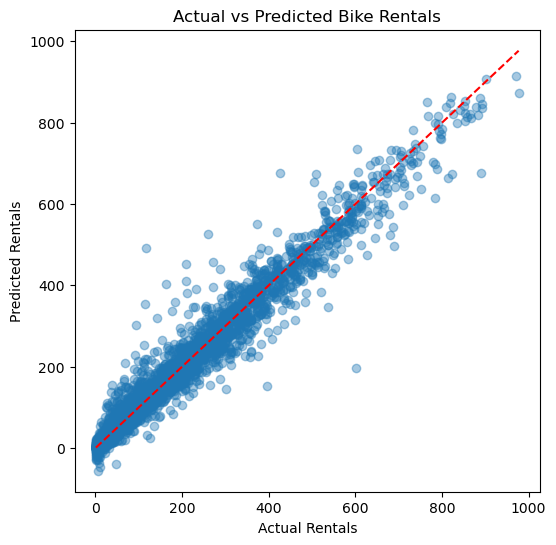

In [61]:
y_pred = hgb_pipeline.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--", color="red")
plt.xlabel("Actual Rentals")
plt.ylabel("Predicted Rentals")
plt.title("Actual vs Predicted Bike Rentals")
plt.show()

#### Distribution of Residuals

The residuals are approximately centered around zero, suggesting that the model does not
exhibit strong systematic bias. Some dispersion is observed for higher rental values,
which is expected in demand prediction problems.

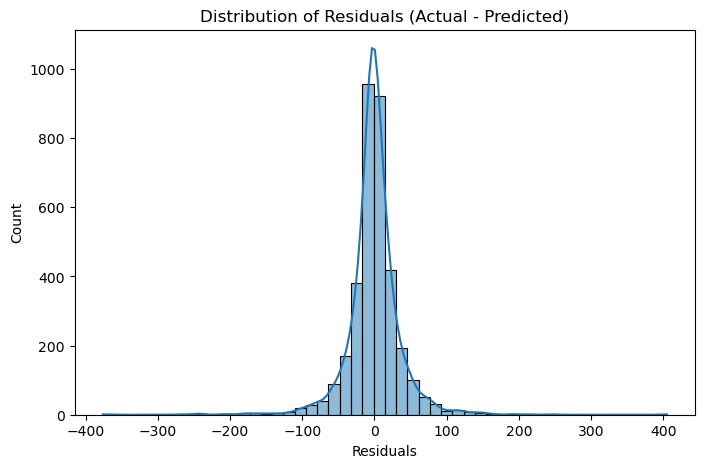

In [62]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Distribution of Residuals (Actual - Predicted)")
plt.xlabel("Residuals")
plt.show()

#### Feature Importance Analysis (Permutation Importance)

Since the HistGradientBoostingRegressor does not provide built-in feature importance scores,
a permutation-based approach was used to assess the contribution of each feature to the
model predictions.

Permutation importance evaluates the decrease in model performance when the values of a
single feature are randomly shuffled. Features that cause a larger performance drop are
considered more important.

In [63]:
# Permutation importance is used because HGB has no feature_importances_
r = permutation_importance(
    hgb_pipeline,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="neg_root_mean_squared_error"
)

perm_imp = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": r.importances_mean
}).sort_values(by="Importance", ascending=False)

perm_imp.head(10)

,Feature,Importance
3,hr,176.158226
6,workingday,55.377648
1,yr,48.593159
8,temp,41.818702
9,hum,16.221470
2,mnth,13.603383
0,season,13.038795
5,weekday,10.700940
7,weathersit,9.386998
11,day,4.917784


The results show that temporal variables, particularly the hour of the day, are the most
influential features. Weather-related variables such as temperature also play a significant
role in the prediction of bike rental demand.

These findings are consistent with the patterns observed during exploratory data analysis,
reinforcing the reliability of the final model.

## Phase 6 - DEPLOYMENT

To demonstrate the practical applicability of the developed model, the final HistGradientBoosting regressor was deployed using a simple Flask web application.

The trained model was saved to disk and later loaded within the web application. A user interface was implemented to allow manual insertion of input features, including temporal and weather-related variables.
The inputs provided by the user are processed and converted into the same feature format used during training. The model then generates a prediction for the expected number of bike rentals for the selected hour.

This deployment step illustrates how the trained model can be used outside the notebook environment and integrated into a real-world application.

In [64]:
import joblib
from pathlib import Path

# Create models folder
Path("models").mkdir(exist_ok=True)

# Save the final trained pipeline
joblib.dump(hgb_pipeline, "models/hgb_pipeline.joblib")

print("Saved model to models/hgb_pipeline.joblib")


Saved model to models/hgb_pipeline.joblib


## Conclusion and Final Considerations

### Model Interpretability
The final selected model, HistGradientBoosting, is a tree-based ensemble model, although it is not fully interpretable like a linear model, its behavior can still be analyzed at a global level.

- Feature importance was used as an interpretability technique to understand the influence of each variable.
- The most important features identified are consistent with the patterns observed during the exploratory data analysis, particularly the relevance of temporal variables.


### Potential Biases in the Data

The dataset is limited to a specific time period (2011–2012) and a single urban context. As a result, the model learns historical patterns that may not fully generalize to different cities or more recent periods. These limitations should be considered when interpreting the model's predictions, especially in different contexts.


### Ethical Considerations
The dataset does not contain sensitive personal information, and the predictions generated by the model do not directly affect individuals. For this reason, the model is intended to be used as a decision-support tool rather than an autonomous decision-making system.

### Continuous Improvement and Retraining
- The model can be retrained when new data becomes available.
- Incorporating more recent data would allow the model to adapt to new trends and usage patterns.
- Periodic retraining can help maintain the model’s performance over time.

### Handling New Data
- A machine learning pipeline was used to ensure consistency between training and inference.
- New input data can be processed using the same feature format as the training data.
- The deployed application allows predictions to be generated for new scenarios outside the notebook environment.

### Future Improvements
- Further hyperparameter tuning could be explored to improve performance.
- Additional explanatory variables could be included if available.
- Advanced interpretability techniques, such as SHAP values, could be applied.
- Evaluation using data from different periods or locations could improve generalization.

### Assessment of the Overall Process
- Overall, the adopted workflow proved to be consistent and aligned with the objectives of the project
- Multiple models were compared against a baseline using appropriate regression metrics.
- Temporal validation strategies increased confidence in the robustness of the final model.